<b>Data Source:</b><br>
<b>Air Quality Time Series data UCI, Aayush Kandpal.</b><br>
<b>Retrived from</b> https://www.kaggle.com/datasets/aayushkandpal/air-quality-time-series-data-uci

# Import Library

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2 
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')
sns.set()

# Preprocess data

In [161]:
raw_csv_data = pd.read_csv("AirQualityUCI.csv") 
df_comp = raw_csv_data.copy()
df_comp['datetime'] = pd.to_datetime(df_comp['Date'] + ' ' + df_comp['Time'], utc=True)
df_comp.set_index('datetime', inplace=True)
df_comp = df_comp[~df_comp.index.duplicated(keep='first')]
df_comp = df_comp.asfreq('H')
df_comp.replace(-200, np.nan, inplace=True)
df_comp.ffill(inplace=True)
df_comp.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
datetime,,,,,,,,,,,,,,,
2004-03-10 18:00:00+00:00,3/10/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00+00:00,3/10/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00+00:00,3/10/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00+00:00,3/10/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00+00:00,3/10/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [163]:
df_comp['target']= df_comp['T'] 

In [165]:
df_comp['target'].describe()

count    9357.000000
mean       18.317356
std         8.821883
min        -1.900000
25%        11.900000
50%        17.600000
75%        24.300000
max        44.600000
Name: target, dtype: float64

We took Temperature as variable to model

<Axes: xlabel='datetime'>

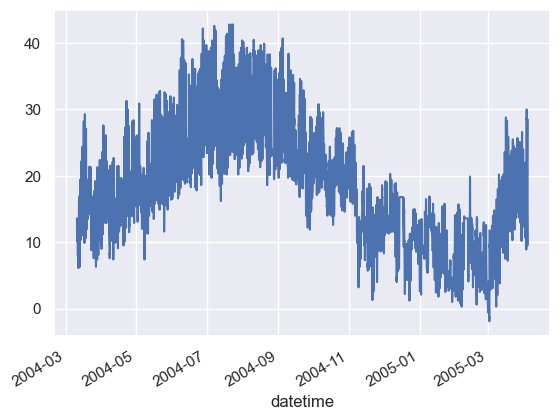

In [137]:
df_comp.target.plot()

# Stationary and differencing

In [140]:
adf_result = adfuller(df_comp['target'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] <= 0.05:
    print("✅ Series is stationary")
else:
    print("⚠️ Series is NOT stationary. Consider differencing.")

ADF Statistic: -3.1998125804833286
p-value: 0.019995530359560153
✅ Series is stationary


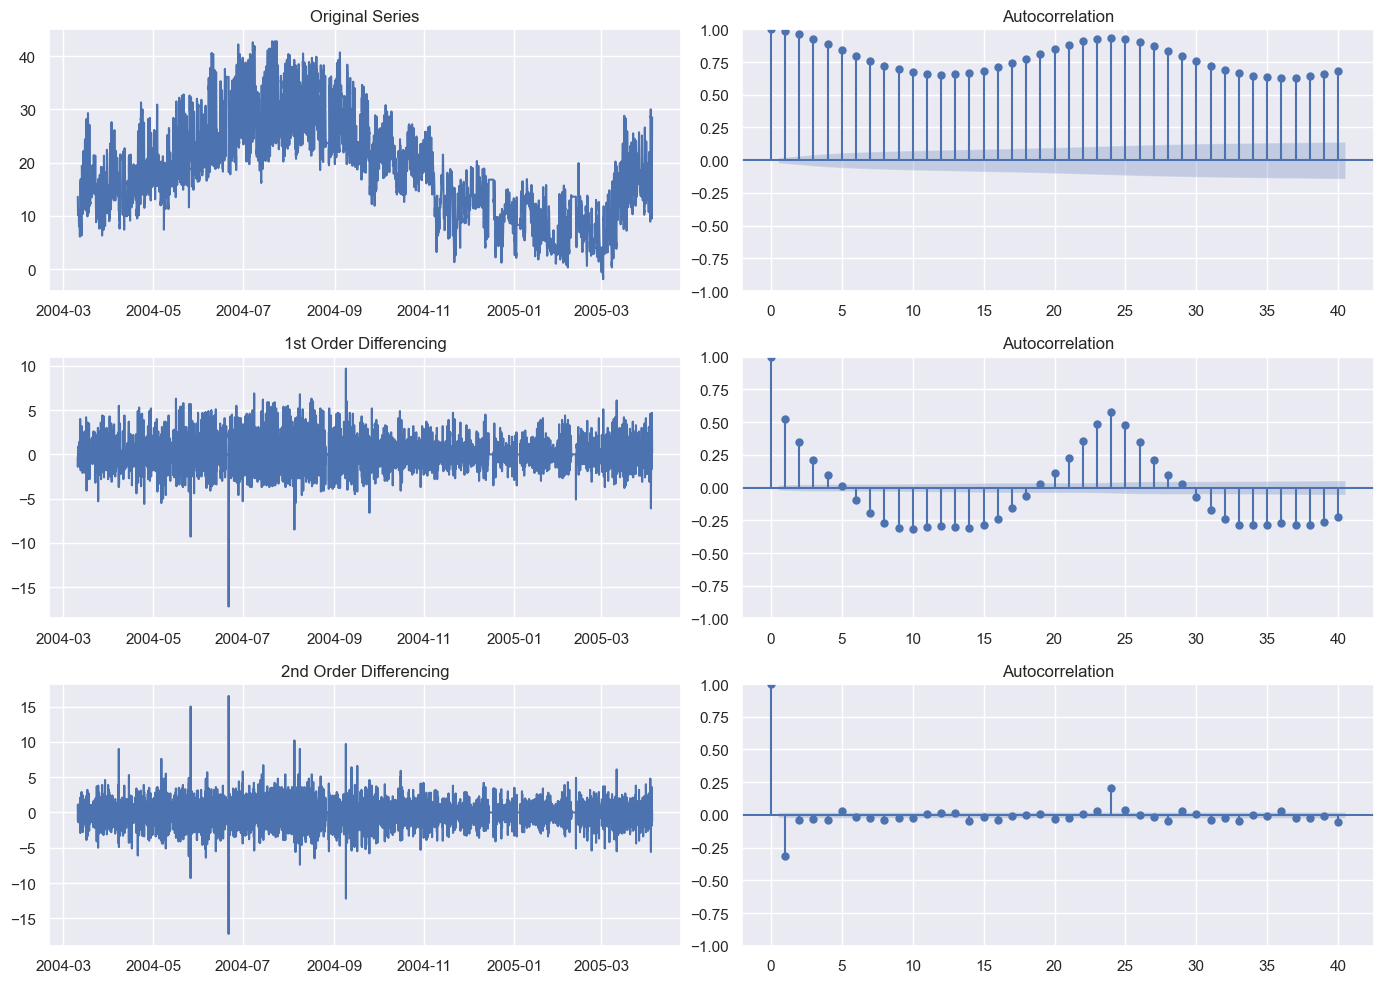

In [142]:
df_comp['target'] = pd.to_numeric(df_comp['target'], errors='coerce')
df_comp = df_comp.dropna(subset=['target'])

# Create differenced series
temp_diff1 = df_comp['target'].diff().dropna()
temp_diff2 = temp_diff1.diff().dropna()

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Plot original series
axes[0, 0].plot(df_comp['target'])
axes[0, 0].set_title('Original Series')
plot_acf(df_comp['target'].dropna(), ax=axes[0, 1], lags=min(40, len(df_comp) // 2))
axes[0, 1].set_title('Autocorrelation')

# 1st order differencing
axes[1, 0].plot(temp_diff1)
axes[1, 0].set_title('1st Order Differencing')
plot_acf(temp_diff1, ax=axes[1, 1], lags=min(40, len(temp_diff1) // 2))
axes[1, 1].set_title('Autocorrelation')

# 2nd order differencing
axes[2, 0].plot(temp_diff2)
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(temp_diff2, ax=axes[2, 1], lags=min(40, len(temp_diff2) // 2))
axes[2, 1].set_title('Autocorrelation')

plt.tight_layout()
plt.show()

### <b>Important notes:</b> Eventhough the ADF Statistic said the raw data already stationary we need to always check the plot to make sure there's no: Trends or drifts, Seasonality, Structural changes or Time-varying mean or variance. Because the ADF doesnt check it for us. Here we know that first order differencing is needed.

In [145]:
df_comp['target'] = df_comp['target'].diff().dropna() #differencing

# Split into Train and Test

In [148]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

# Volatility Diagnostics Plot

In [174]:
df['target_sq'] = df.target.mul(df.target) 
df_test['target_sq'] = df_test.target.mul(df_test.target) 

Target squere to calculated volatility cluster in the data

In [234]:
df = df[(df['target'].abs() <= 10)]  
df_test = df_test[(df_test['target'].abs() <= 10)]

In real-world temperature readings, a > 10°C/hour change is extremely rare and often indicates:<br>
    Sensor spike or drop<br>
    Logging error<br>
    Missing hours<br>

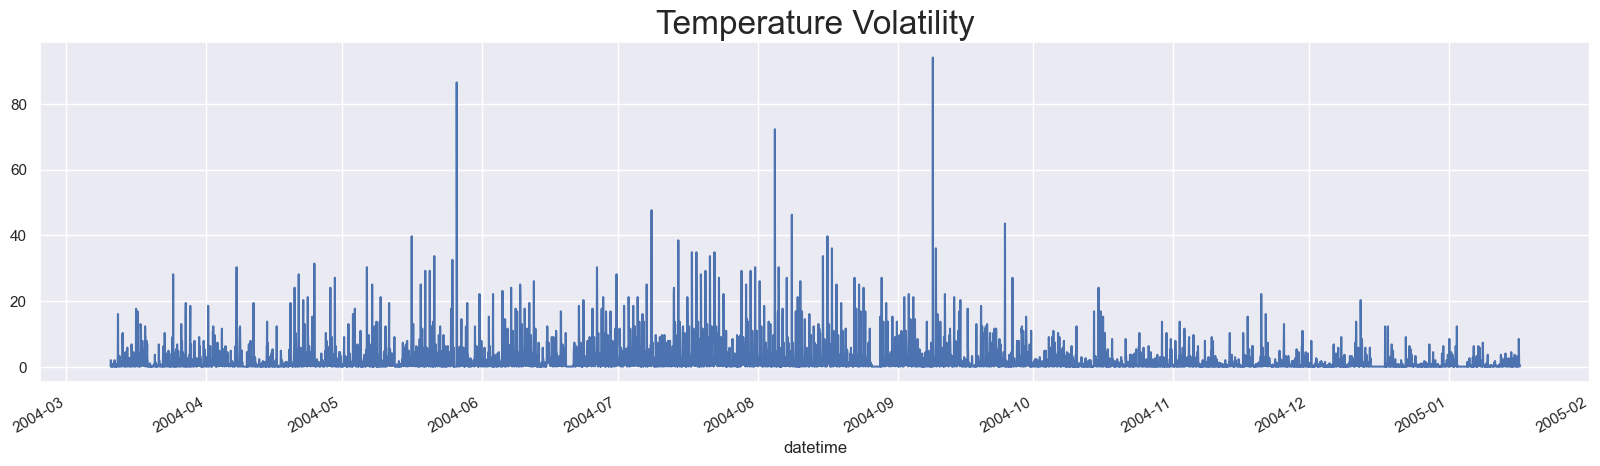

In [183]:
df.target_sq.plot(figsize=(20,5))
plt.title("Temperature Volatility", size = 24)
plt.show()

Visible volatility clustering is present.

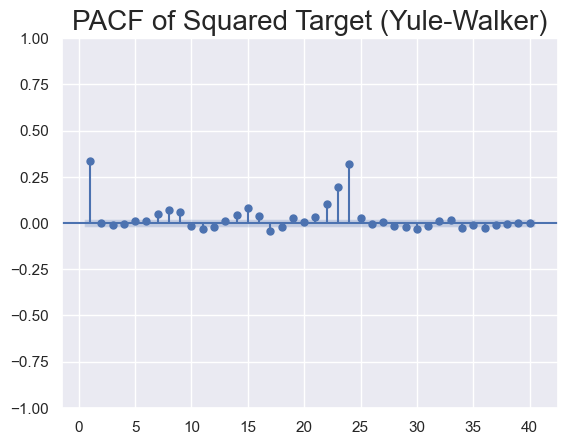

In [186]:
sgt.plot_pacf(df.target_sq.dropna(), lags=40, alpha=0.05, zero=False, method='ywm')
plt.title("PACF of Squared Target (Yule-Walker)", size=20)
plt.show()

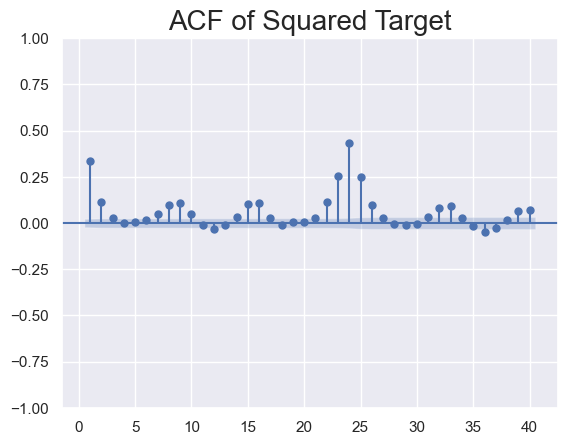

In [188]:
plot_acf(df.target_sq.dropna(), lags=40, alpha=0.05, zero=False)
plt.title("ACF of Squared Target", size=20)
plt.show()

Remember: Use ARCH or GARCH if and only if ACF/PACF of squared returns show significant autocorrelation. <br>
Otherwise: ARCH or GARCH will just fit noise & Forecasts will be unstable or meaningless

# Find the best parameter ARCH & GARCH Model

In [192]:
from arch import arch_model

best_arch_model = None
best_arch_aic = float('inf')
best_arch_order = None

for p in range(1, 6):  # Try ARCH(1) to ARCH(5)
    model = arch_model(df.target.dropna(), vol='ARCH', p=p)
    res = model.fit(disp='off')
    print(f"ARCH({p}) AIC: {res.aic}")
    if res.aic < best_arch_aic:
        best_arch_aic = res.aic
        best_arch_model = res
        best_arch_order = p

print(f"\n✅ Best ARCH model: ARCH({best_arch_order}) with AIC: {best_arch_aic:.2f}")

ARCH(1) AIC: 24863.996803022837
ARCH(2) AIC: 24772.33613346186
ARCH(3) AIC: 24752.286370196176
ARCH(4) AIC: 24733.508563370273
ARCH(5) AIC: 24720.901694693268

✅ Best ARCH model: ARCH(5) with AIC: 24720.90


In [194]:
model_arch = arch_model(df.target.dropna(), vol='ARCH', p=5)
results_arch = model_arch.fit()
print(results_arch.summary())

Iteration:      1,   Func. Count:      9,   Neg. LLF: 71616.70026338617
Iteration:      2,   Func. Count:     23,   Neg. LLF: 19554.64878696512
Iteration:      3,   Func. Count:     34,   Neg. LLF: 159674.35438061887
Iteration:      4,   Func. Count:     43,   Neg. LLF: 327355.82413625775
Iteration:      5,   Func. Count:     52,   Neg. LLF: 13653.076257137463
Iteration:      6,   Func. Count:     61,   Neg. LLF: 13070.621451382467
Iteration:      7,   Func. Count:     70,   Neg. LLF: 13050.139036919358
Iteration:      8,   Func. Count:     79,   Neg. LLF: 12478.087363095574
Iteration:      9,   Func. Count:     88,   Neg. LLF: 12438.283653000875
Iteration:     10,   Func. Count:     97,   Neg. LLF: 12396.67152213951
Iteration:     11,   Func. Count:    106,   Neg. LLF: 12821.742883537041
Iteration:     12,   Func. Count:    115,   Neg. LLF: 12371.547712114172
Iteration:     13,   Func. Count:    124,   Neg. LLF: 12768.198513103845
Iteration:     14,   Func. Count:    134,   Neg. LLF: 

In [196]:
best_garch_model = None
best_garch_aic = float('inf')
best_garch_order = None

for p in range(1, 4):  # Try p = 1 to 3
    for q in range(1, 4):  # Try q = 1 to 3
        model = arch_model(df.target.dropna(), vol='GARCH', p=p, q=q)
        res = model.fit(disp='off')
        print(f"GARCH({p},{q}) AIC: {res.aic}")
        if res.aic < best_garch_aic:
            best_garch_aic = res.aic
            best_garch_model = res
            best_garch_order = (p, q)

print(f"\n✅ Best GARCH model: GARCH{best_garch_order} with AIC: {best_garch_aic:.2f}")


GARCH(1,1) AIC: 24745.719466714916
GARCH(1,2) AIC: 24726.730589249695
GARCH(1,3) AIC: 24703.0114148598
GARCH(2,1) AIC: 24747.71946673505
GARCH(2,2) AIC: 24728.730588153743
GARCH(2,3) AIC: 24705.011415170295
GARCH(3,1) AIC: 24743.807157498715
GARCH(3,2) AIC: 24730.730588380735
GARCH(3,3) AIC: 24707.011415735677

✅ Best GARCH model: GARCH(1, 3) with AIC: 24703.01


In [198]:
garch_mod = arch_model(df.target.dropna(), mean = "Constant", vol='GARCH', p=1, q=3)
garch_res = garch_mod.fit()
print(garch_res.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 172963.58699286642
Iteration:      2,   Func. Count:     20,   Neg. LLF: 124203.9058484534
Iteration:      3,   Func. Count:     28,   Neg. LLF: 12616.283571204076
Iteration:      4,   Func. Count:     36,   Neg. LLF: 12617.90604246251
Iteration:      5,   Func. Count:     44,   Neg. LLF: 33147.62572758393
Iteration:      6,   Func. Count:     52,   Neg. LLF: 12539.253414674124
Iteration:      7,   Func. Count:     60,   Neg. LLF: 12379.902309251089
Iteration:      8,   Func. Count:     68,   Neg. LLF: 12499.976155068276
Iteration:      9,   Func. Count:     76,   Neg. LLF: 12346.553823301272
Iteration:     10,   Func. Count:     83,   Neg. LLF: 12373.141969699038
Iteration:     11,   Func. Count:     91,   Neg. LLF: 12421.527107082935
Iteration:     12,   Func. Count:     99,   Neg. LLF: 12345.508080874362
Iteration:     13,   Func. Count:    106,   Neg. LLF: 12345.505754464193
Iteration:     14,   Func. Count:    113,   Neg. LLF: 

# Evaluation

In [200]:
from statsmodels.stats.diagnostic import acorr_ljungbox
resid_std = best_garch_model.resid / best_garch_model.conditional_volatility
lb_test = acorr_ljungbox(resid_std.dropna()**2, lags=[10], return_df=True)
print(lb_test)

      lb_stat  lb_pvalue
10  14.497141   0.151499


 GARCH model has successfully captured the volatility clustering in the data.

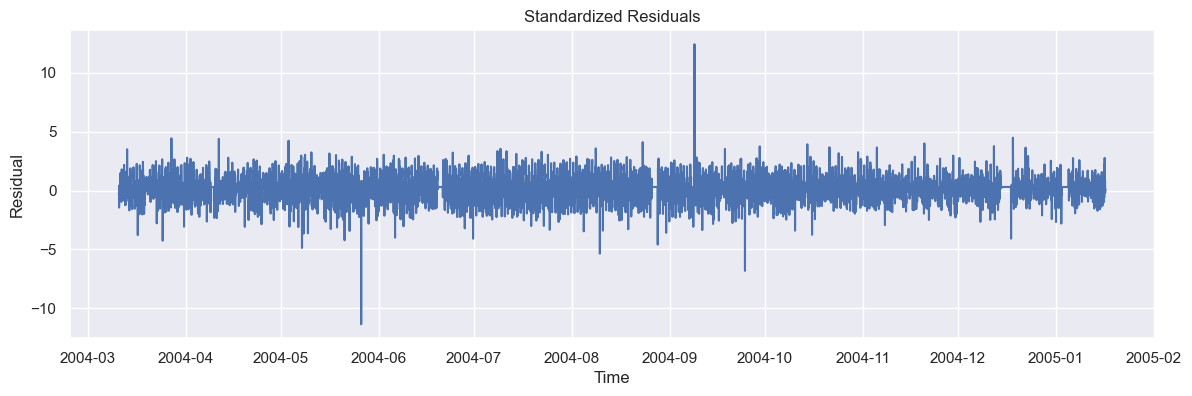

In [202]:
plt.figure(figsize=(14, 4))
plt.plot(resid_std)
plt.title('Standardized Residuals')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

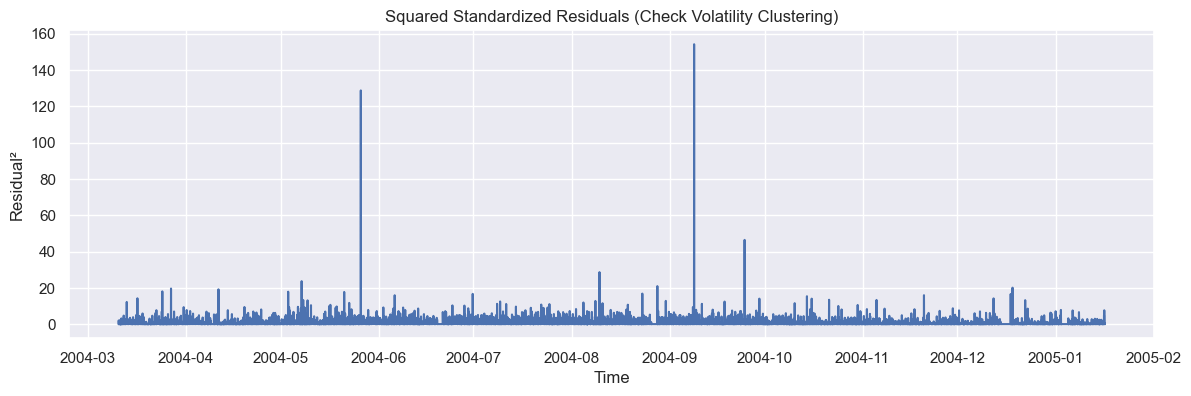

In [204]:
plt.figure(figsize=(14, 4))
plt.plot(resid_std**2)
plt.title('Squared Standardized Residuals (Check Volatility Clustering)')
plt.xlabel('Time')
plt.ylabel('Residual²')
plt.grid(True)
plt.show()

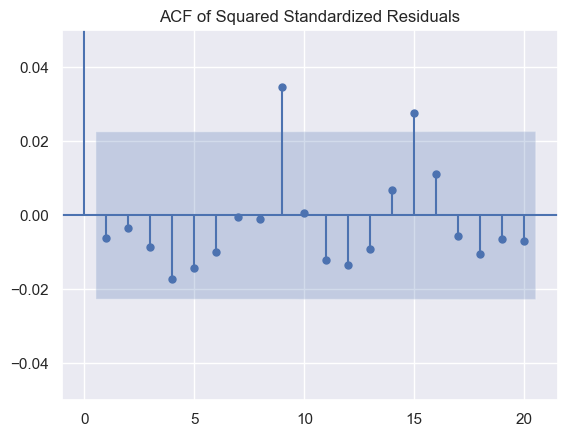

In [213]:
plot_acf(resid_std.dropna()**2, lags=20)
plt.title("ACF of Squared Standardized Residuals")
plt.ylim(-0.050,0.050)
plt.show()

After modeling with GARCH, the residual volatility behaves like white noise — no predictable structure left.

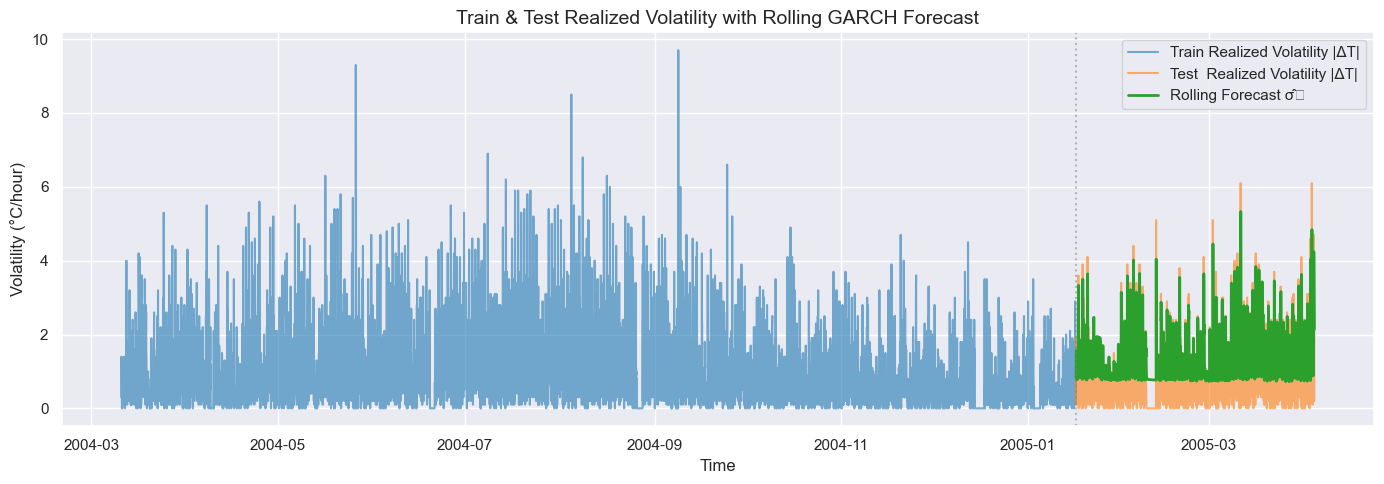

In [256]:
history = df['target'].copy()
rolling_vol = []

for t in df_test.index:
    m = arch_model(history, mean="Constant", vol="GARCH", p=1, q=3)
    r = m.fit(disp="off")
    
    f = r.forecast(horizon=1)
    var1 = f.variance.values[-1, 0]      
    rolling_vol.append(np.sqrt(var1))     
    new_obs = pd.Series(df_test.loc[t, 'target'], index=[t])
    history = pd.concat([history, new_obs])

forecast_dyn = pd.Series(rolling_vol, index=df_test.index)

train_real = df['target'].abs()
test_real  = df_test['target'].abs()

plt.figure(figsize=(14,5))

plt.plot(train_real.index, train_real,
         label='Train Realized Volatility',
         color='tab:blue', alpha=0.6)

plt.plot(test_real.index, test_real,
         label='Test Realized Volatility',
         color='tab:orange', alpha=0.6)

plt.plot(forecast_dyn.index, forecast_dyn,
         label='Rolling Forecast', 
         color='tab:green', linewidth=2)

plt.axvline(x=df_test.index[0], color='gray', linestyle=':', alpha=0.5)

plt.title("Train & Test Realized Volatility with Rolling GARCH Forecast", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Volatility (°C/hour)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
